In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle as pkl
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function
from tqdm import tqdm

#Importing libraries used for SVM classification and model assessment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#Libraries for CNN model
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json
from keras.utils import to_categorical

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset, dataset_PCA, Tuned_SVM_train, SVM_predictions, load_dataset_CNN, image_array_resize

Using TensorFlow backend.


# 1. Loading Trained Multiclass CNN Model and Datasets


In [2]:
# load Multiclass CNN json and create model
json_file = open(".\Models\MultiClassification\CNN\Multiclass_CNN.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN_Multiclass = model_from_json(loaded_model_json)
# load weights into new model
CNN_Multiclass.load_weights(".\Models\MultiClassification\CNN\Multiclass_CNN_Model_Weights")
print("Loaded model from disk")

Loaded model from disk


In [3]:
#Do the same for our CNN images resized to 50
CNN_Images = image_array_resize('dataset\Extra_test_dataset\image',50)

#Adding 4th channel to array (for convnet fitting)
#The last channel is indicating whether it is a RGB channel (3) or grayscale (1) image
CNN_Images_4D = CNN_Images.reshape(200,50,50,1)

#Getting our Y and X inputs for the model and scaling the X inputs
#Carrying out scaling of the pixel data per element so that it is between 0 and 1
xTest_CNN = CNN_Images_4D/255

100%|██████████| 200/200 [00:00<00:00, 216.26it/s]

Successfully extracted original Images from dataset!


In [4]:
#Loading the CSV Label file
extra_test_labels = pd.read_csv('./dataset/Extra_test_dataset/label.csv')

#Taking just the label portion for editing into our Target Y array
Y = extra_test_labels[['label']]
Y_np = Y.to_numpy()

#Initialises empty array for Y data for multiclass task
Y_Multiclass = np.zeros(len(Y_np))

#For loop runs through array to check which elements are of the different class names
#It will then edit the respective index element in Y_Multiclass with the respective integer label we give to the class
for x in range(len(Y_np)):

    if Y_np[x] == 'no_tumor':
        Y_Multiclass[x] = 0
    
    elif Y_np[x] == 'glioma_tumor':
        Y_Multiclass[x] = 1

    elif Y_np[x] == 'meningioma_tumor':
        Y_Multiclass[x] = 2

    else:
        Y_Multiclass[x] = 3

print("Multiclass label array setup!")

Multiclass label array setup!


In [5]:
#Making Predictions with the model
#We make 2 sets of predictions using the trained model. One which predicts the absolute class of the test image 
#and another subsequently which provides probability of the labels (0 or 1). The latter is used for ROC curve plotting
Multiclass_CNN_pred = CNN_Multiclass.predict_classes(xTest_CNN, verbose = 1)

#Printing the classification report and metrics
print("The Results for Multiclass CNN are:")
print(classification_report(Y_Multiclass, Multiclass_CNN_pred))

#Printing the confusion matrix for Multiclass CNN
print("The confusion matrix is:")
print(confusion_matrix(Y_Multiclass, Multiclass_CNN_pred))

200/200 [==============================] - 11s 53ms/step
The Results for Multiclass CNN are:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85        37
         1.0       0.69      0.84      0.76        43
         2.0       0.86      0.65      0.74        68
         3.0       0.81      0.98      0.89        52

    accuracy                           0.81       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.82      0.81      0.80       200

The confusion matrix is:
[[30  1  2  4]
 [ 2 36  5  0]
 [ 2 14 44  8]
 [ 0  1  0 51]]


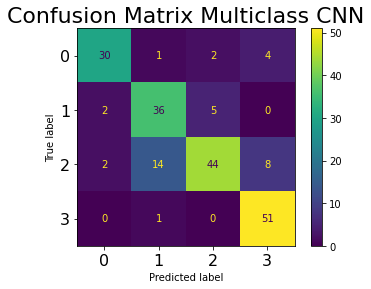

In [6]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_Multiclass, Multiclass_CNN_pred ))

cm_plot.plot()
#Labels for title and axis
plt.title('Confusion Matrix Multiclass CNN', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#Saves plot to be used in the report COMMENTED OUT SO IT WONT OVERWRITE PLOTS FOR NOW
#plt.savefig('./Plots/CM_Eval_Multiclass_CNN.jpg', bbox_inches='tight')

In [7]:
#Converting prediction labels into one hot format for roc_auc_score
Y_Multiclass_OH = to_categorical(Y_Multiclass)
Multiclass_CNN_pred_OH = to_categorical(Multiclass_CNN_pred)
#Printing the main metrics to assess performance of the Multiclass CNN model
print("The metrics for Multiclass CNN model are as follows")
print('roc_auc_score for Multiclass CNN: ', roc_auc_score(Y_Multiclass_OH, Multiclass_CNN_pred_OH, average= 'macro', multi_class= 'ovo'))

The metrics for Multiclass CNN model are as follows
roc_auc_score for Multiclass CNN:  0.876910759749695
